In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class TimeSeriesData():
    
    def __init__(self, num_points, xmin, xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        
        # Grab a random starting point for each data
        rand_start = np.random.rand(batch_size,1)
        
        # Convert to be on time series
        ts_start = rand_start*(self.xmax-self.xmin-(steps*self.resolution))
        
        # create batch time series on the x axis
        batch_ts = ts_start + np.arange(0.0,steps+1)*(self.resolution)
        
        # create the Y data for the time series x axis from previous step
        y_batch = np.sin(batch_ts)
        
        # Formatting for RNN
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1)
        

In [3]:
ts_data = TimeSeriesData(250,0,10)

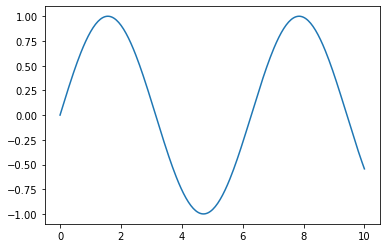

In [4]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [5]:
num_time_steps = 30

In [6]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)

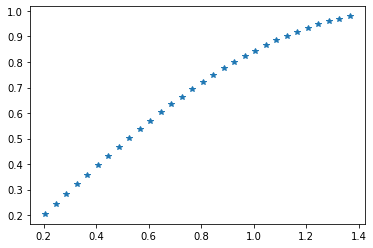

In [7]:
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

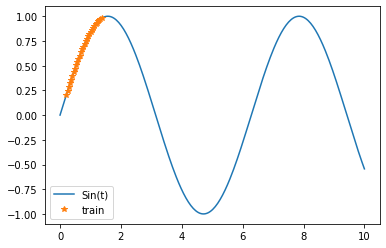

In [8]:
plt.plot(ts_data.x_data, ts_data.y_true, label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='train')
plt.legend()
plt.tight_layout

In [9]:
# Training Data

train_inst = np.linspace(5,5+ts_data.resolution*(num_time_steps+1), num_time_steps+1)

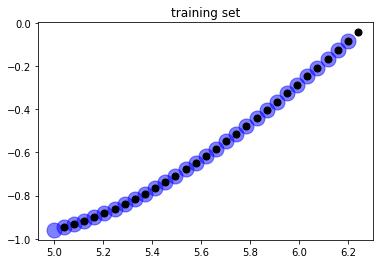

In [10]:
plt.title('training set')

plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]),'bo', markersize=15, alpha=0.5, label='Instance')

plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]),'ko',markersize=7, label='TARGET')

# Creating the Model

In [11]:
tf.reset_default_graph()

In [12]:
num_inputs = 1

num_neurons = 100

num_outputs = 1

learning_rate = 0.0001

num_train_iterations = 2000

batch_size = 1

In [13]:
# Place Holders

X = tf.placeholder(tf.float32,[None,num_time_steps, num_inputs])

y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [14]:
# RNN Cell Layer

cell = tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation = tf.nn.relu)

cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=num_outputs)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [15]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
# MSE

loss = tf.reduce_mean(tf.square(outputs-y))

In [17]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [18]:
init = tf.global_variables_initializer()

In [19]:
saver = tf.train.Saver()

In [20]:
with tf.Session() as sess:
    
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        
        sess.run(train, feed_dict = {X:X_batch, y:y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X:X_batch, y:y_batch})
            
            print(iteration,'\tMSE', mse)
            
    saver.save(sess,'./rnn_time_series_model_codealong')

0 	MSE 0.1867782
100 	MSE 0.21143068
200 	MSE 0.03614288
300 	MSE 0.023237403
400 	MSE 0.004220083
500 	MSE 0.015923757
600 	MSE 0.004712158
700 	MSE 0.017035518
800 	MSE 0.029102307
900 	MSE 0.019067563
1000 	MSE 0.0025612826
1100 	MSE 0.010268223
1200 	MSE 0.00051071774
1300 	MSE 0.006369608
1400 	MSE 0.0265558
1500 	MSE 0.026949743
1600 	MSE 0.020706989
1700 	MSE 0.0012618654
1800 	MSE 0.0005436204
1900 	MSE 0.0134065505


In [21]:
with tf.Session() as sess:
    
    saver.restore(sess,'./rnn_time_series_model_codealong')
    
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps, num_inputs)))
    
    y_pred = sess.run(outputs, feed_dict={X:X_new})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


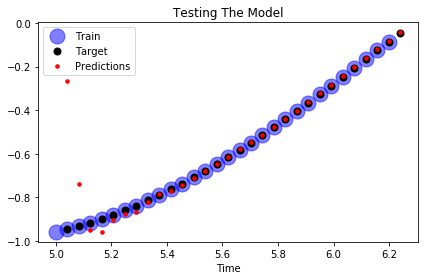

In [22]:
plt.title('Testing The Model')

# Training Instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]),'bo',markersize=15, alpha=0.5, label='Train')

# Target to Predict
plt.plot(train_inst[1:], np.sin(train_inst[1:]),'ko',markersize=7,label='Target')


# Model Prediction
plt.plot(train_inst[1:], y_pred[0,:,0],'r.', markersize=7, label='Predictions')

plt.xlabel('Time')
plt.legend()
plt.tight_layout()


# Generating New Sequence

In [23]:
with tf.Session() as sess:
    
    saver.restore(sess, './rnn_time_series_model_codealong')
    
    #SEED ZEROS
    zero_seq_seed = [0.0 for i in range(num_time_steps)]
    
    for iteration in range(len(ts_data.x_data)-num_time_steps):
        
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        
        y_pred = sess.run(outputs, feed_dict={X:X_batch})
        
        zero_seq_seed.append(y_pred[0,-1,0])       

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


Text(0, 0.5, 'y')

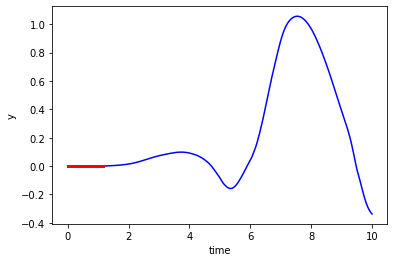

In [24]:
plt.plot(ts_data.x_data, zero_seq_seed,'b-')
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps],'r',linewidth=3)
plt.xlabel('time')
plt.ylabel('y')

In [26]:
with tf.Session() as sess:
    
    saver.restore(sess, './rnn_time_series_model_codealong')
    
    #SEED ZEROS
    training_instance = list(ts_data.y_true[:30])
    
    for iteration in range(len(ts_data.x_data)-num_time_steps):
        
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1,num_time_steps,1)
        
        y_pred = sess.run(outputs, feed_dict={X:X_batch})
        
        training_instance.append(y_pred[0,-1,0])       

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong


Text(0, 0.5, 'y')

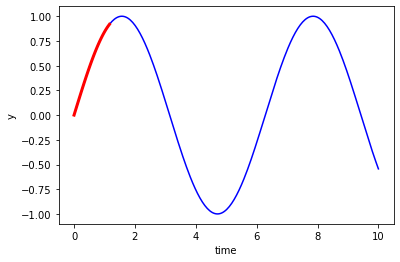

In [28]:
plt.plot(ts_data.x_data, ts_data.y_true,'b-')
plt.plot(ts_data.x_data[:num_time_steps], training_instance[:num_time_steps],'r',linewidth=3)
plt.xlabel('time')
plt.ylabel('y')